### Построение концептуальной модели

Содержательное описание

Объект моделирования - **Больница скорой помощи**

В больнице скорой помощи имеется 4 мобильные бригады. При поступлении звонка свободная бригада выезжает к больному, где оказывает помощь на месте или везет больного в стационар. После оказания помощи на месте при наличии очереди вызовов бригада сразу отправляется к новому больному.

**Основные элементы системы**:
- **Вызовы** - звонки больных, поступающие в систему.
- **Очередь вызовов** - единая FIFO (First In First Out) очередь вызовов. Вызов становится в очередь сразу после приёма и обрабатывается при наличии свободной мобильной бригады.
- **Мобильные бригады** - идентичные обработчики вызова в количестве 4-х единиц.

Концептуальная модель

**Единица модельного времени** - 1 минута.

**Переменные модели и их распределение во времени**:
- **Поток вызовов** - пуассоновский поток. Новый вызов формируется в случайный момент времени.
- **Количество мобильных бригад** постоянное.
- **Время приёма вызова** распределено нормально.
- **Время обработки вызова** также распределено нормально.

**Допущения и ограничения модели**:
- Приём вызова происходит без формирования очереди на приём.
- Способ обработки вызова не влияет на реализацию программной имитации модели.
- Вызов нельзя отменить. После попадания вызова в очередь он обязательно будет обработан.
- Мобильная бригада обрабатывает вызовы последовательно, т.е. только 1 вызов в определённый момент времени.
- Между временем приёма вызова и временем обработки вызова нет зависимости.

**Отклики модели**:
- **Среднее время ожидания в очереди вызовов `AVG_QUEUE`** - дискретный отклик.
- **Среднее время цикла обслуживания `AVG_SYSTEM`** - дискретный отклик. В цикл обслуживания входят этапы с приёма вызова и до завершения его обработки.
- **Длина очереди `QUEUE_LEN`** - непрерывный отклик.
- **Загруженность бригад `BRIGADES_LOAD`** - непрерывный отклик. Загруженность в момент времени рассчитывается как отношение количества мобильных бригад на обработке вызова в момент времени к количеству мобильных бригад.
- **Количество обработанных вызовов `CALLS_PROC`** - аддитивный отклик. Обработанным вызовом считается вызов, прошедший полный цикл обслуживания.

##### Программная имитационнонная модель

**Параметры модели**:
- `RUN_TIME` - время работы модели в минутах.
- `NUM_BRIGADE` - количество мобильных бригад (4 по описанию модели).
- `FREQUENCY_MIN` - минимальная частота поступления вызовов.
- `FREQUENCY_MAX` - минимальная частота поступления вызовов.
- `NUM_REPLICATIONS` - количество прогонов.
- `AVG_RECEPTION_TIME` - среднее время приёма вызова.
- `AVG_PROCESSING_TIME` - среднее время обработки вызова.

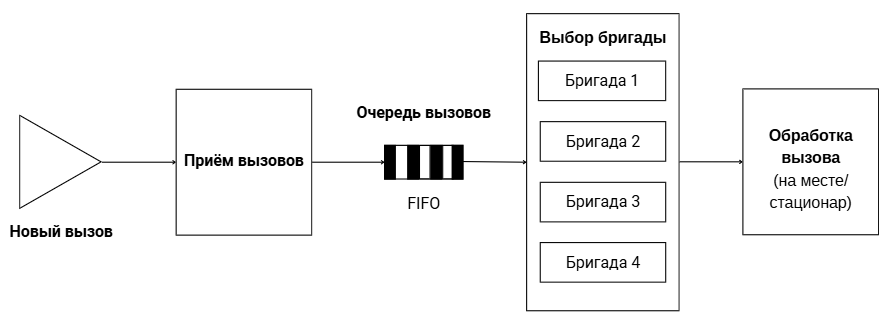

### Программная имитационная модель

In [2]:
!pip install simpy

In [3]:
import random
import numpy as np
import simpy
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
RUN_TIME = 1200
NUM_BRIGADES = 4

FREQUENCY = 4
AVG_RECEPTION_TIME = 4
AVG_PROCESSING_TIME = 45
NUM_REPLICATIONS = 1000

INIT_CALLS = 0

TRACE_MODE = False
WITH_CLEARANCE = True
TEST_MODE = False
WARMUP_MODE = False
WARMUP_TIME = 180

FREQ_MIN = 5
FREQ_MAX = 15

AVG_RECEPTION_TIME_MIN = 5
AVG_RECEPTION_TIME_MAX = 30

AVG_PROCESSING_TIME_MIN = 30
AVG_PROCESSING_TIME_MAX = 60

In [5]:
CUR_PARAMS = ['AVG_QUEUE', 'AVG_SYSTEM']
CON_PARAMS = ['QUEUE_LEN', 'BRIGADES_LOAD']
ADD_PARAMS = ['CALLS_PROC']
ALL_PARAMS = CUR_PARAMS + CON_PARAMS + ADD_PARAMS

class Results_Collector():
  def __init__(self):
    self.current_values = {param: [] for param in CUR_PARAMS}
    self.continuous_values = {param: [] for param in CON_PARAMS}
    self.additive_values = {param: [] for param in ADD_PARAMS}
    self.replication_values = {param: [] for param in ALL_PARAMS}
    self.freq_avgs = {param: [] for param in ALL_PARAMS}

  def add_current_value(self, param, time, value):
    self.current_values[param].append((time, value))

  def add_continuous_value(self, param, time, value):
    self.continuous_values[param].append((time, value))

  def add_additive_values(self, param, time, value):
    self.additive_values[param].append((time, value))

  def calculate_discrete_avg(self, param):
    values = [point[1] for point in self.current_values[param]]
    return sum(values)/len(values)

  def calculate_continuous_avg(self, param):
    if len(self.continuous_values[param]) < 2:
      return 0
    samples = sorted(self.continuous_values[param], key = lambda x: x[0])
    total_time = samples[-1][0] - samples[0][0]
    if total_time <=0:
      return 0
    weighted_sum = 0
    for i in range(1, len(samples)):
      start_time, start_value = samples[i-1]
      end_time, end_value = samples[i]
      interval = end_time-start_time
      weighted_sum += start_value * interval
    return weighted_sum/total_time

  def finalize_replication(self):
    for param in CON_PARAMS:
      if self.continuous_values[param]:
        self.replication_values[param].append(self.calculate_continuous_avg(param))

    for param in CUR_PARAMS:
      if self.current_values[param]:
        self.replication_values[param].append(self.calculate_discrete_avg(param))

    for param in ADD_PARAMS:
      if self.additive_values[param]:
        self.replication_values[param].append(self.additive_values[param][-1][1])
    self.clear_values()

  def calculate_replications_avg(self):
    for param in CUR_PARAMS:
      self.freq_avgs[param].append(sum(self.replication_values[param])/len(self.replication_values[param]))
    for param in CON_PARAMS:
      self.freq_avgs[param].append(sum(self.replication_values[param])/len(self.replication_values[param]))
    for param in ADD_PARAMS:
      self.freq_avgs[param].append(sum(self.replication_values[param])/len(self.replication_values[param]))
    self.replication_values = {param: [] for param in ALL_PARAMS}
    return self.freq_avgs

  def show_results(self, run_time):
    print("== ADDITIVE PARAMS:")
    for param in self.additive_values:
      if self.additive_values[param]:
        print(f"{param} : {self.additive_values[param][-1][1]}")

    print("== DISCRETE PARAMS:")
    for param in self.current_values:
      if self.current_values[param]:
        sorted_data = sorted(self.current_values[param], key=lambda x: x[0])
        times = [point[0] for point in sorted_data]
        values = [point[1] for point in sorted_data]
        avg = self.moving_avg(values)
        print(f"{param} avg: {self.calculate_discrete_avg(param)}")
        plt.figure(figsize=(8, 5))
        plt.scatter(times, values, color='skyblue', alpha=0.7, s=50)
        plt.plot(times, avg, color='green', linewidth=2, label='Скользящее среднее')
        plt.axvline(x=run_time, color='lightcoral', linestyle='--', label=f'Время работы модели: {run_time}')
        plt.xlabel('Время')
        plt.ylabel(f'Значение {param}')
        plt.title(f'График {param} во времени')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

    print("== CONTINUOUS PARAMS")
    for param in self.continuous_values:
      if self.continuous_values[param]:
        sorted_data = sorted(self.continuous_values[param], key=lambda x: x[0])
        times = [point[0] for point in sorted_data]
        values = [point[1] for point in sorted_data]
        avg = self.moving_avg(values)
        print(f"{param} avg: {self.calculate_continuous_avg(param)}")
        plt.figure(figsize=(8, 5))
        plt.plot(times, avg, color='green', linewidth=2, label='Скользящее среднее')
        plt.plot(times, values, color = 'skyblue', marker='o', linestyle='-', linewidth=1, markersize=4)
        plt.axvline(x=run_time, color='lightcoral', linestyle='--', label=f'Время работы модели: {run_time}')
        plt.xlabel('Время')
        plt.ylabel(f'Значение {param}')
        plt.title(f'График {param}')
        plt.grid(True, alpha=0.3)
        plt.show()

  def show_replications_results(self, replications_num):
    header = f"{'№':<4}"
    for param in ALL_PARAMS:
      header += f" {param:<15}"
    print(header)
    print("-" * (12 + 13 * len(ALL_PARAMS)))
    for i in range(replications_num):
      row = f"{i+1:<4}"
      for param in ALL_PARAMS:
          if i < len(RESULTS_COLLECTOR.replication_values[param]):
              value = RESULTS_COLLECTOR.replication_values[param][i]
              row += f" {value:<15.4f}"
          else:
              row += f" {'N/A':<15}"
      print(row)
    print("-" * (12 + 13 * len(ALL_PARAMS)))
    row = f"{'AVG':<4}"
    for param in ALL_PARAMS:
      avg = sum(RESULTS_COLLECTOR.replication_values[param])/len(RESULTS_COLLECTOR.replication_values[param])
      row += f" {avg:<15.4f}"
    print(row)
    print()

  def moving_avg(self, data):
    result = []
    for i in range(1, len(data)+1):
      avg = sum(data[:i])/i
      result.append(avg)
    return result


  def clear_values(self):
    self.current_values = {param: [] for param in CUR_PARAMS}
    self.continuous_values = {param: [] for param in CON_PARAMS}
    self.additive_values = {param: [] for param in ADD_PARAMS}

In [6]:
class Emergency_Hospital:
  def __init__(self, env, num_brigades, reception_time, processing_time, trace = False, test = False):
    self.env = env
    self.brigades = simpy.Resource(env, num_brigades)
    self.reception_time = reception_time
    self.processing_time = processing_time
    self.trace = trace
    self.test = test
    self.processed_calls = 0
    self.received_calls = 0
    self.queue_len = 0
    self.busy_brigades = 0
    RESULTS_COLLECTOR.add_continuous_value('QUEUE_LEN', 0, 0)
    RESULTS_COLLECTOR.add_continuous_value('BRIGADES_LOAD', 0, 0)

  def _trace(self, message):
    if self.trace:
      print(f"[Time: {self.env.now:.2f}] {message}")

  def receive_call(self, call_id):
    self._trace(f"Call {call_id} on line. Time {self.env.now}")
    system_entry_time = self.env.now
    if TEST_MODE: reception_time = self.reception_time
    else: reception_time = max(1, np.random.normal(self.reception_time, 1.5))
    yield self.env.timeout(reception_time)
    self._trace(f"Call {call_id} received. Time {self.env.now}")
    self.received_calls += 1
    self.env.process(self.process_call(call_id, system_entry_time))

  def process_call(self, call_id, system_entry_time):
    queue_entry_time = self.env.now
    self.queue_len += 1
    self._trace(f"Call {call_id} in queue. Time {queue_entry_time}")
    RESULTS_COLLECTOR.add_continuous_value('QUEUE_LEN', queue_entry_time, self.queue_len)
    with self.brigades.request() as request:
      yield request
      queue_exit_time = self.env.now
      self.queue_len -= 1
      self._trace(f"Call {call_id} in processing. Time {queue_exit_time}")
      self.busy_brigades += 1
      current_load = self.busy_brigades / NUM_BRIGADES
      RESULTS_COLLECTOR.add_continuous_value('BRIGADES_LOAD', queue_exit_time, self.busy_brigades)
      RESULTS_COLLECTOR.add_continuous_value('QUEUE_LEN', queue_exit_time, self.queue_len)
      RESULTS_COLLECTOR.add_current_value('AVG_QUEUE', queue_exit_time, queue_exit_time - queue_entry_time)
      processing_time = max(10, np.random.normal(self.processing_time, 12))
      yield self.env.timeout(processing_time)
      system_exit_time = self.env.now
      self.busy_brigades -= 1
      current_load = self.busy_brigades / NUM_BRIGADES
      RESULTS_COLLECTOR.add_continuous_value('BRIGADES_LOAD', system_exit_time, self.busy_brigades)
      RESULTS_COLLECTOR.add_current_value('AVG_SYSTEM', system_exit_time, system_exit_time - system_entry_time)
      self.processed_calls += 1
      self._trace(f"Call {call_id} processed. Time {system_exit_time}")
      RESULTS_COLLECTOR.add_additive_values('CALLS_PROC', self.env.now, self.processed_calls)

In [7]:
def call_generator(env, emergency_hospital, frequency, until_time = RUN_TIME):

  def start_call(call_id):
    env.process(emergency_hospital.receive_call(call_id))

  call_id = 1
  for i in range(INIT_CALLS):
    start_call(call_id)
    call_id += 1

  while env.now < until_time:
    if TEST_MODE: interval = frequency/60
    else: interval = random.expovariate(frequency/60)
    yield env.timeout(interval)
    start_call(call_id)
    call_id += 1

In [8]:
def run_simulation(frequency, reception_time, processing_time):
  warmup = 0 if not WARMUP_MODE else WARMUP_TIME
  total_time = warmup + RUN_TIME
  env = simpy.Environment()
  emergency_hospital = Emergency_Hospital(env, NUM_BRIGADES, reception_time, processing_time, False, False)

  env.process(call_generator(env, emergency_hospital, frequency, total_time))

  if WARMUP_MODE:
    env.run(until=warmup)
    warmup_queue = emergency_hospital.queue_len
    warmup_processing = emergency_hospital.busy_brigades
    warmup_processed = emergency_hospital.processed_calls
    RESULTS_COLLECTOR.clear_values()
    RESULTS_COLLECTOR.add_continuous_value('QUEUE_LEN', 0, warmup_queue)
    RESULTS_COLLECTOR.add_continuous_value('BRIGADES_LOAD', 0, warmup_processing)
    emergency_hospital.processed_calls = 0
    emergency_hospital.received_calls = 0
    if WITH_CLEARANCE:
      env.run(None)
    else:
      env.run(until=warmup + RUN_TIME)
  else:
    if WITH_CLEARANCE: env.run(None)
    else: env.run(until=RUN_TIME)
  RESULTS_COLLECTOR.add_continuous_value('QUEUE_LEN', env.now, emergency_hospital.queue_len)
  RESULTS_COLLECTOR.add_additive_values('CALLS_PROC', env.now, emergency_hospital.processed_calls)
  RESULTS_COLLECTOR.add_continuous_value('BRIGADES_LOAD', env.now, emergency_hospital.busy_brigades/NUM_BRIGADES)

Single Test

== ADDITIVE PARAMS:
CALLS_PROC : 86
== DISCRETE PARAMS:
AVG_QUEUE avg: 8.079571092820448


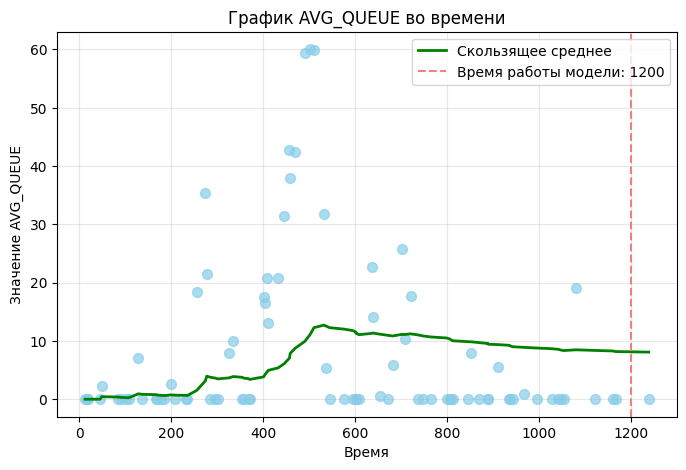

AVG_SYSTEM avg: 56.91045916431601


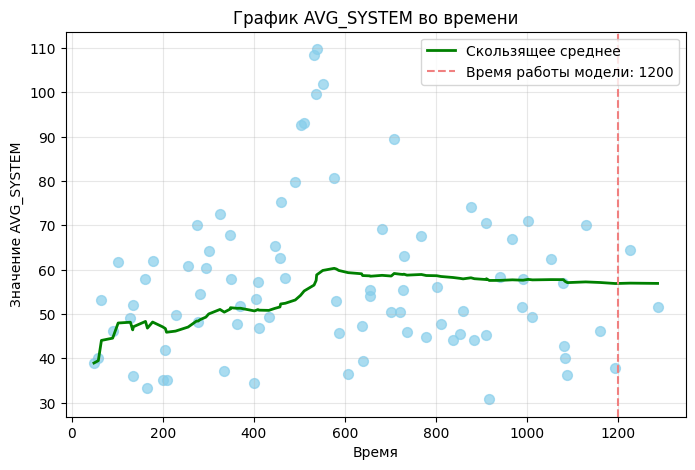

== CONTINUOUS PARAMS
QUEUE_LEN avg: 0.5396857191810804


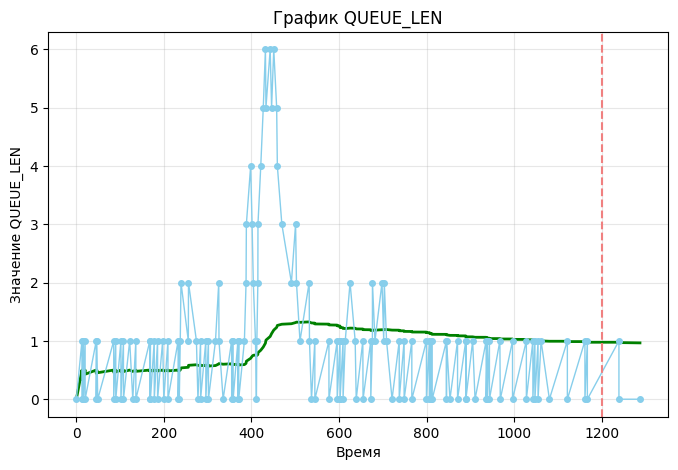

BRIGADES_LOAD avg: 2.9913875537747394


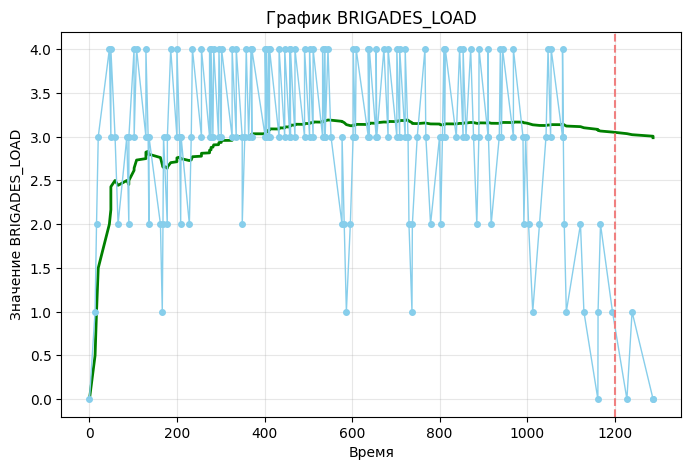

In [9]:
TEST_MODE = False
RESULTS_COLLECTOR = Results_Collector()
run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
RESULTS_COLLECTOR.show_results(RUN_TIME)

Replications

In [10]:
TEST_MODE = False
RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
  RESULTS_COLLECTOR.finalize_replication()
RESULTS_COLLECTOR.show_replications_results(NUM_REPLICATIONS)

№    AVG_QUEUE       AVG_SYSTEM      QUEUE_LEN       BRIGADES_LOAD   CALLS_PROC     
-----------------------------------------------------------------------------
1    28.0044         78.3859         2.1212          3.5024          100.0000       
2    10.8970         57.9877         0.7708          3.0550          89.0000        
3    3.7936          51.1606         0.2334          2.6666          77.0000        
4    14.2378         60.9701         0.9660          2.8968          87.0000        
5    9.0129          60.0561         0.5308          2.7709          76.0000        
6    11.4620         60.6753         0.7150          2.8176          79.0000        
7    9.9462          55.9231         0.6263          2.6517          80.0000        
8    8.4929          58.5186         0.5205          2.7920          76.0000        
9    4.7154          51.4098         0.3102          2.8079          83.0000        
10   4.0525          53.0162         0.2369          2.6261          74.

#### Tests

##### Увеличение частоты получения вызовов увеличивает нагрузку на систему

In [11]:
RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQ_MIN, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
  RESULTS_COLLECTOR.finalize_replication()
results_1 = RESULTS_COLLECTOR.calculate_replications_avg()

RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQ_MAX, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
  RESULTS_COLLECTOR.finalize_replication()
results_2 = RESULTS_COLLECTOR.calculate_replications_avg()

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, param in enumerate(ALL_PARAMS):
    values = [results_1[param][0], results_2[param][0]]
    if results_1[param][0] < results_2[param][0]:
      print(f"Для параметра {param} гипотеза подтвердилась")
    else:
      print(f"Для параметра {param} гипотеза не подтвердилась")
    labels = ['FREQ_MIN', 'FREQ_MAX']

    bars = axes[i].bar(labels, values, color=['skyblue', 'lightcoral'])
    axes[i].set_title(param)
    axes[i].set_ylabel('Значение')

    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom')

if len(ALL_PARAMS) < len(axes):
    for i in range(len(ALL_PARAMS), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

##### Увеличение времени обработки вызова увеличивает длину очереди и время в системе

In [ ]:
RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME_MIN)
  RESULTS_COLLECTOR.finalize_replication()
results_1 = RESULTS_COLLECTOR.calculate_replications_avg()

RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME_MAX)
  RESULTS_COLLECTOR.finalize_replication()
results_2 = RESULTS_COLLECTOR.calculate_replications_avg()

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, param in enumerate(['AVG_QUEUE', 'AVG_SYSTEM', 'QUEUE_LEN']):
    values = [results_1[param][0], results_2[param][0]]
    if results_1[param][0] < results_2[param][0]:
      print(f"Для параметра {param} гипотеза подтвердилась")
    else:
      print(f"Для параметра {param} гипотеза не подтвердилась")
    labels = ['PROC_MIN', 'PROC_MAX']

    bars = axes[i].bar(labels, values, color=['skyblue', 'lightcoral'])
    axes[i].set_title(param)
    axes[i].set_ylabel('Значение')

    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom')

if len(ALL_PARAMS) < len(axes):
    for i in range(len(ALL_PARAMS), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


##### Увеличение времени получения вызова должно увеличить время нахождения в системе, но уменьшить среднее время нахождения в очереди и длину самой очереди

In [ ]:
RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQUENCY, AVG_RECEPTION_TIME_MIN, AVG_PROCESSING_TIME)
  RESULTS_COLLECTOR.finalize_replication()
results_1 = RESULTS_COLLECTOR.calculate_replications_avg()

RESULTS_COLLECTOR = Results_Collector()
for _ in range(NUM_REPLICATIONS):
  run_simulation(FREQUENCY, AVG_RECEPTION_TIME_MAX, AVG_PROCESSING_TIME)
  RESULTS_COLLECTOR.finalize_replication()
results_2 = RESULTS_COLLECTOR.calculate_replications_avg()

if results_1['AVG_QUEUE'][0] > results_2['AVG_QUEUE'][0]:
  print(f"Для параметра 'AVG_QUEUE' гипотеза подтвердилась")
else: print(f"Для параметра 'AVG_QUEUE' гипотеза не подтвердилась")

if results_1['AVG_SYSTEM'][0] < results_2['AVG_SYSTEM'][0]:
  print(f"Для параметра 'AVG_SYSTEM' гипотеза подтвердилась")
else: print(f"Для параметра 'AVG_SYSTEM' гипотеза не подтвердилась")

if results_1['QUEUE_LEN'][0] > results_2['QUEUE_LEN'][0]:
  print(f"Для параметра 'QUEUE_LEN' гипотеза подтвердилась")
else: print(f"Для параметра 'QUEUE_LEN' гипотеза не подтвердилась")

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes = axes.flatten()

for i, param in enumerate(['AVG_QUEUE', 'AVG_SYSTEM', 'QUEUE_LEN']):
    values = [results_1[param][0], results_2[param][0]]
    labels = ['PROC_MIN', 'PROC_MAX']

    bars = axes[i].bar(labels, values, color=['skyblue', 'lightcoral'])
    axes[i].set_title(param)
    axes[i].set_ylabel('Значение')

    for bar in bars:
        height = bar.get_height()
        axes[i].text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.2f}', ha='center', va='bottom')

if len(ALL_PARAMS) < len(axes):
    for i in range(len(ALL_PARAMS), len(axes)):
        fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


### Исследование свойств имитационной модели

In [12]:
RESULTS_COLLECTOR = Results_Collector()

#### Хи-квадрат

In [13]:
def chi_square(data, param_name, alpha=0.05):
    data = np.array(data)
    n = len(data)
    if n < 30:
        print(f"!!! {param_name}: Мало данных для теста Хи-квадрат (n={n})")
        return

    mu = np.mean(data)
    sigma = np.std(data, ddof=1)

    k = int(1 + 3.322 * np.log10(n))
    observed_freq, bin_edges = np.histogram(data, bins=k)

    expected_freq = []
    for i in range(k):
        lower = -np.inf if i == 0 else bin_edges[i]
        upper = np.inf if i == k - 1 else bin_edges[i+1]

        prob = stats.norm.cdf(upper, loc=mu, scale=sigma) - stats.norm.cdf(lower, loc=mu, scale=sigma)
        expected_freq.append(prob * n)

    expected_freq = np.array(expected_freq)
    observed_freq = np.array(observed_freq)

    obs_merged = []
    exp_merged = []

    temp_obs = 0
    temp_exp = 0

    for o, e in zip(observed_freq, expected_freq):
        temp_obs += o
        temp_exp += e
        if temp_exp >= 5:
            obs_merged.append(temp_obs)
            exp_merged.append(temp_exp)
            temp_obs = 0
            temp_exp = 0

    if temp_exp > 0:
        if len(obs_merged) > 0:
            obs_merged[-1] += temp_obs
            exp_merged[-1] += temp_exp
        else:
            obs_merged.append(temp_obs)
            exp_merged.append(temp_exp)

    new_k = len(obs_merged)
    df = new_k - 1 - 2

    if df <= 0:
        print(f"!!! {param_name}: Недостаточно интервалов после объединения для теста.")
        return

    chi2_stat, p_val = stats.chisquare(f_obs=obs_merged, f_exp=exp_merged, ddof=2)
    critical_value = stats.chi2.ppf(1 - alpha, df)

    print(f"--- Результаты теста для: {param_name} ---")
    print(f"Статистика Хи-квадрат: {chi2_stat:.4f}")
    print(f"Критическое значение: {critical_value:.4f}")
    print(f"p-value: {p_val:.4f}")

    if p_val > alpha:
        print(f"Результат: Гипотеза принимается (данные распределены нормально)")
    else:
        print(f"Результат: Гипотеза отвергается (распределение отличается от нормального)")
    print("-" * 40)

    plt.figure(figsize=(7, 4))
    count, bins, ignored = plt.hist(data, bins=k, density=True, alpha=0.5, color='lightblue', label='Гистограмма')
    x = np.linspace(min(data), max(data), 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma), 'r-', lw=2, label=f'Norm (μ={mu:.1f}, σ={sigma:.1f})')
    plt.title(f"Нормальность: {param_name}")
    plt.legend()
    plt.show()

--- Результаты теста для: AVG_QUEUE ---
Статистика Хи-квадрат: 12.2401
Критическое значение: 5.9915
p-value: 0.0022
Результат: Гипотеза отвергается (распределение отличается от нормального)
----------------------------------------


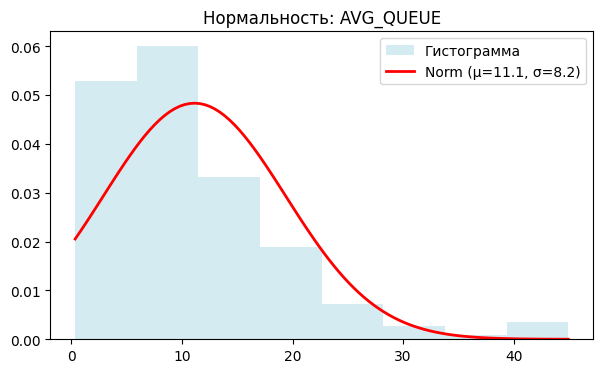

--- Результаты теста для: AVG_SYSTEM ---
Статистика Хи-квадрат: 11.6778
Критическое значение: 5.9915
p-value: 0.0029
Результат: Гипотеза отвергается (распределение отличается от нормального)
----------------------------------------


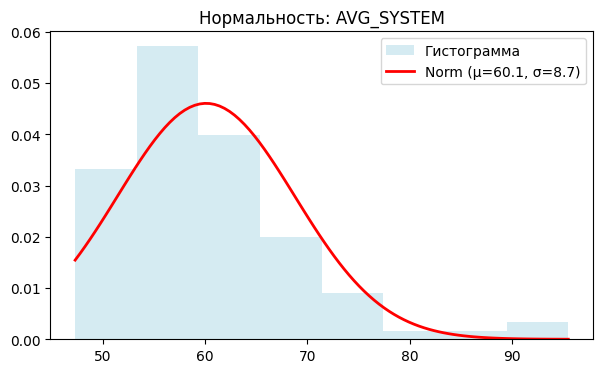

--- Результаты теста для: QUEUE_LEN ---
Статистика Хи-квадрат: 15.5674
Критическое значение: 5.9915
p-value: 0.0004
Результат: Гипотеза отвергается (распределение отличается от нормального)
----------------------------------------


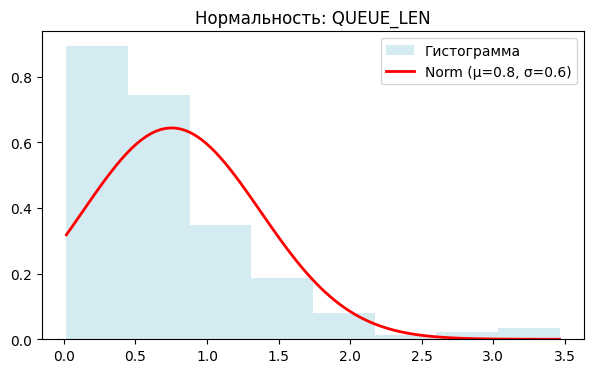

--- Результаты теста для: BRIGADES_LOAD ---
Статистика Хи-квадрат: 0.9977
Критическое значение: 9.4877
p-value: 0.9101
Результат: Гипотеза принимается (данные распределены нормально)
----------------------------------------


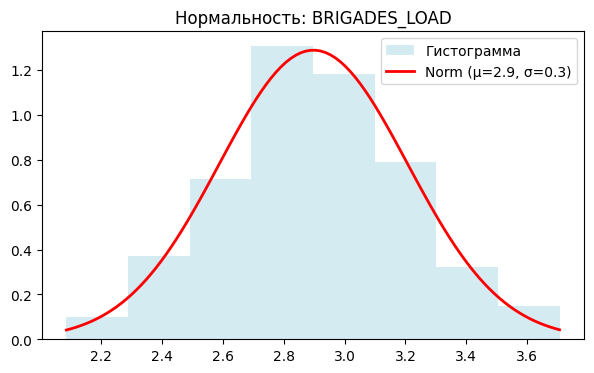

--- Результаты теста для: CALLS_PROC ---
Статистика Хи-квадрат: 1.4263
Критическое значение: 9.4877
p-value: 0.8396
Результат: Гипотеза принимается (данные распределены нормально)
----------------------------------------


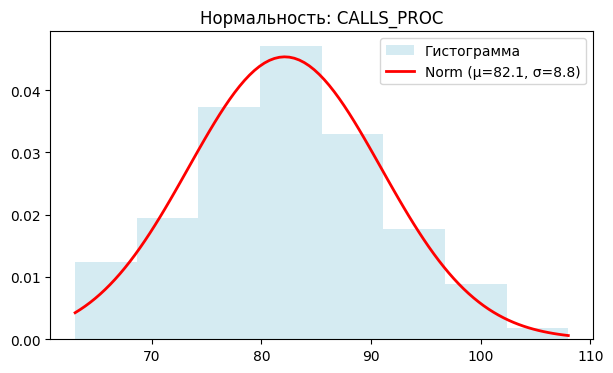

In [14]:
RESULTS_COLLECTOR = Results_Collector()
for i in range(200):
  run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
  RESULTS_COLLECTOR.finalize_replication()

for param in ALL_PARAMS:
  data = RESULTS_COLLECTOR.replication_values[param]
  chi_square(data, param)

#### Точечные и интервальные оценки откликов

In [15]:
def calculate_confidence_intervals():
    global NUM_REPLICATIONS
    OLD_REPS = NUM_REPLICATIONS

    current_n = 20
    NUM_REPLICATIONS = current_n
    alpha = 0.05
    confidence_level = 1 - alpha

    RESULTS_COLLECTOR.clear_values()
    RESULTS_COLLECTOR.replication_values = {param: [] for param in ALL_PARAMS}

    for i in range(current_n):
        run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
        RESULTS_COLLECTOR.finalize_replication()
    header = f"| {'Параметр':<15} | {'Точечная оценка':<18} | {'Интервальная оценка (95%)':<30} | {'Точность':<10} |"
    print(header)

    for param in ALL_PARAMS:
        data = RESULTS_COLLECTOR.replication_values[param]
        point_estimate = np.mean(data)
        standard_error = stats.sem(data)
        ci_lower, ci_upper = stats.t.interval(confidence_level, df=len(data)-1, loc=point_estimate, scale=standard_error)
        margin_of_error = point_estimate - ci_lower
        if ci_lower < 0 and param in ['AVG_QUEUE', 'QUEUE_LEN', 'BRIGADES_LOAD', 'AVG_SYSTEM']:
            ci_lower = 0.0

        print(f"| {param:<15} | {point_estimate:<18.4f} | {ci_lower:<9.4f} ... {ci_upper:<16.4f} | +/-{margin_of_error:<7.4f} |")
    NUM_REPLICATIONS = OLD_REPS


In [16]:
def show_plots():
    conf = 0.95
    fig, axes = plt.subplots(2, 3, figsize=(15, 8))
    fig.suptitle(f'Точечные и интервальные оценки (N={len(RESULTS_COLLECTOR.replication_values[ALL_PARAMS[0]])}, alpha=0.05)', fontsize=16)

    params_list = list(ALL_PARAMS)

    for idx, ax in enumerate(axes.flat):
        if idx >= len(params_list):
            ax.axis('off')
            continue

        param = params_list[idx]
        data = RESULTS_COLLECTOR.replication_values[param]
        n = len(data)
        mean = np.mean(data)
        sem = stats.sem(data)

        ci = stats.t.interval(conf, df=n-1, loc=mean, scale=sem)

        x_jitter = np.random.normal(0, 0.05, size=n)
        ax.scatter(x_jitter, data, alpha=0.3, color='dodgerblue', s=30, label='Результаты прогонов')

        ax.plot(0, mean, 'ro', markersize=8, label='Точечная оценка (среднее)')

        ax.axhline(y=ci[0], color='red', linestyle='--', linewidth=1.5, alpha=0.8, label='Границы ДИ (95%)')
        ax.axhline(y=ci[1], color='red', linestyle='--', linewidth=1.5, alpha=0.8)

        ax.axhspan(ci[0], ci[1], facecolor='red', alpha=0.05)

        ax.set_title(param, fontsize=12, fontweight='bold')
        ax.set_xticks([])
        ax.grid(True, axis='y', alpha=0.2, linestyle=':')

        ax.text(0.98, 0.98, f"μ = {mean:.2f}", color='red', fontweight='bold',
                transform=ax.transAxes, ha='right', va='top', fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        ax.text(0.98, 0.88, f"ДИ: [{max(0, ci[0]):.2f}, {ci[1]:.2f}]", color='darkgreen',
                transform=ax.transAxes, ha='right', va='top', fontsize=9,
                bbox=dict(boxstyle='round,pad=0.2', facecolor='white', alpha=0.8))
    handles, labels = axes[0,0].get_legend_handles_labels()
    fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.98, 0.94))

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

| Параметр        | Точечная оценка    | Интервальная оценка (95%)      | Точность   |
| AVG_QUEUE       | 11.0334            | 7.1127    ... 14.9540          | +/-3.9206  |
| AVG_SYSTEM      | 59.8042            | 55.6447   ... 63.9637          | +/-4.1595  |
| QUEUE_LEN       | 0.7509             | 0.4384    ... 1.0634           | +/-0.3125  |
| BRIGADES_LOAD   | 2.8378             | 2.6655    ... 3.0101           | +/-0.1723  |
| CALLS_PROC      | 80.4500            | 75.7785   ... 85.1215          | +/-4.6715  |


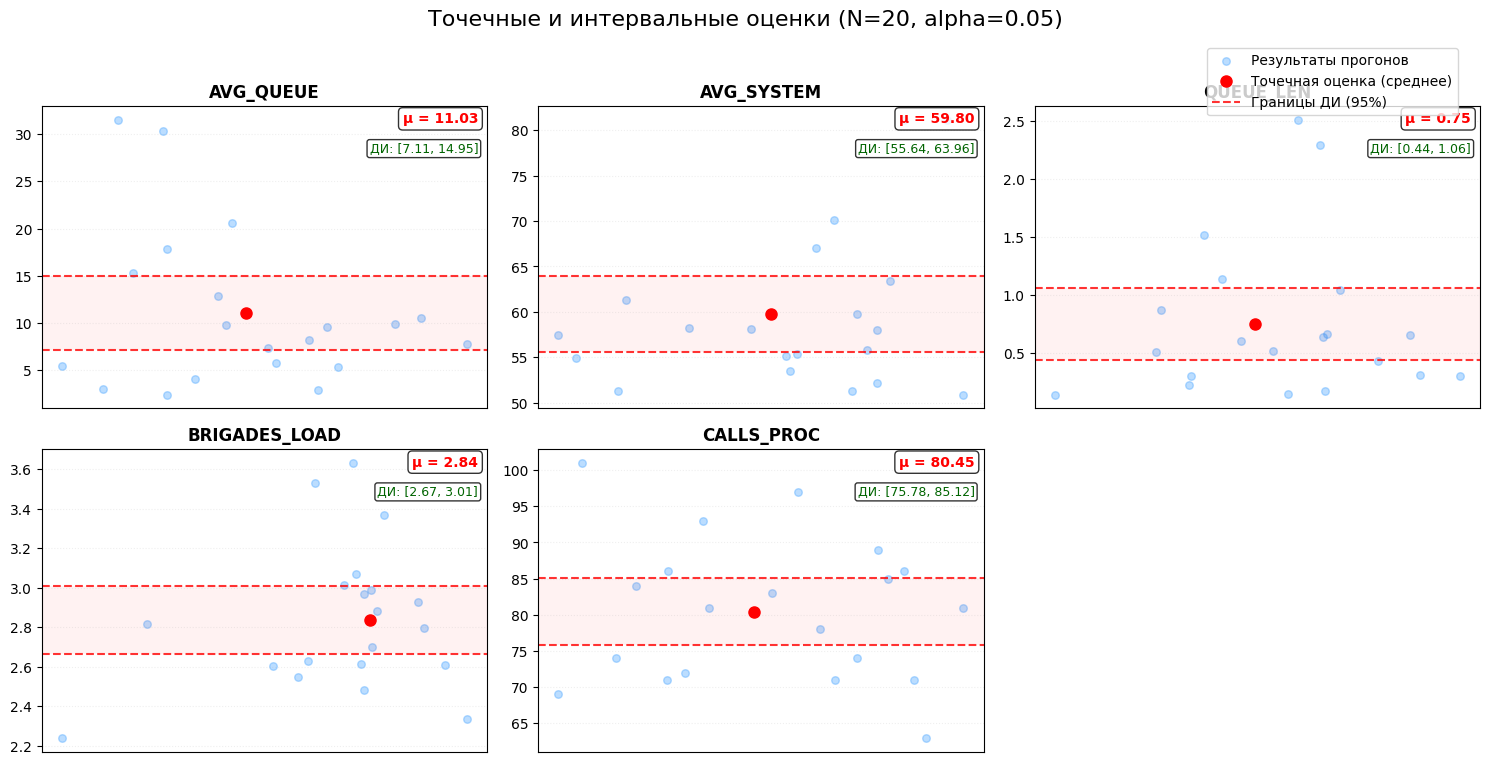

In [17]:
calculate_confidence_intervals()
show_plots()

#### Зависимость относительной погрешности от числа прогонов

In [18]:
def analyze_all_params_precision(max_reps=300, target_error=0.05):
    RESULTS_COLLECTOR.clear_values()
    RESULTS_COLLECTOR.replication_values = {param: [] for param in ALL_PARAMS}

    for i in range(max_reps):
        run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
        RESULTS_COLLECTOR.finalize_replication()

    n_params = len(ALL_PARAMS)
    cols = 3
    rows = (n_params + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    fig.suptitle(f'Зависимость относительной погрешности от числа прогонов', fontsize=20)
    axes = axes.flatten()

    print(f"\n{'Параметр':<15} | {'Тек. ошибка':<12} | {'N для 5%':<10}")
    print("-" * 45)

    for idx, param in enumerate(ALL_PARAMS):
        data = np.array(RESULTS_COLLECTOR.replication_values[param])

        ns = []
        errors = []
        found_n = None

        for n in range(10, max_reps + 1):
            subset = data[:n]
            mean = np.mean(subset)
            std = np.std(subset, ddof=1)

            if mean <= 0:
                rel_error = 0
            else:
                t_val = stats.t.ppf(1 - 0.05/2, df=n-1)
                rel_error = (t_val * (std / np.sqrt(n))) / mean

            ns.append(n)
            errors.append(rel_error)

            if found_n is None and rel_error <= target_error:
                found_n = n

        ax = axes[idx]
        ax.plot(ns, errors, color='dodgerblue', linewidth=2, label='Погрешность')
        ax.axhline(y=target_error, color='red', linestyle='--', alpha=0.7, label='Цель 5%')

        if found_n:
            ax.axvline(x=found_n, color='green', linestyle=':', linewidth=2)
            ax.scatter([found_n], [target_error], color='green', s=60, zorder=5)
            ax.set_title(f"{param}\n(N достигнуто: {found_n})", fontweight='bold')
        else:
            ax.set_title(f"{param}\n-", fontweight='bold', color='darkred')

        ax.set_xlabel('N прогонов')
        ax.set_ylabel('Относительная ошибка')
        ax.grid(True, alpha=0.3)
        ax.set_ylim(0, max(errors) * 1.1 if errors else 1)

        current_err = errors[-1] * 100
        print(f"{param:<15} | {current_err:<11.2f}% | {found_n if found_n else '>'+str(max_reps)}")

    for i in range(idx + 1, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Параметр        | Тек. ошибка  | N для 5%  
---------------------------------------------
AVG_QUEUE       | 5.00       % | 1000
AVG_SYSTEM      | 0.98       % | 24
QUEUE_LEN       | 5.63       % | >1000
BRIGADES_LOAD   | 0.71       % | 19
CALLS_PROC      | 0.70       % | 10


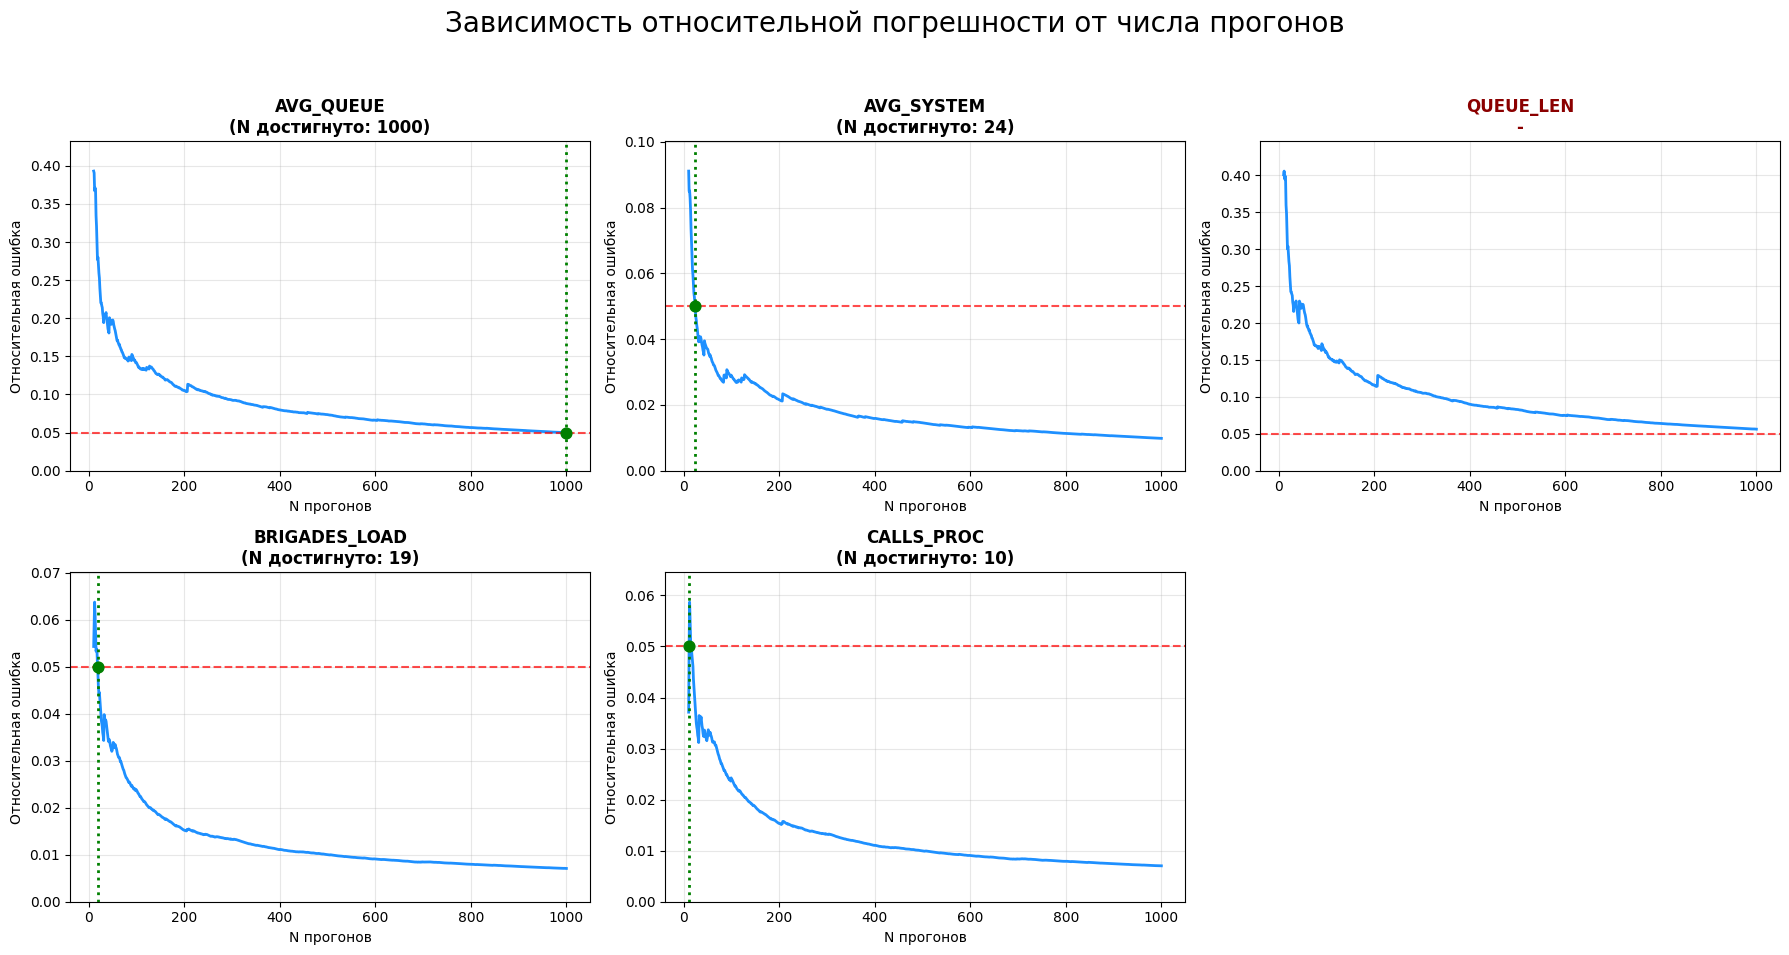

In [19]:
analyze_all_params_precision(max_reps=1000, target_error=0.05)

#### Переходный период

In [20]:
def analyze_warmup_full_study(num_reps=120):
    global WARMUP_MODE
    original_mode = WARMUP_MODE

    WARMUP_MODE = False
    test_env = simpy.Environment()
    test_hospital = Emergency_Hospital(test_env, NUM_BRIGADES, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
    RESULTS_COLLECTOR.clear_values()
    test_env.process(call_generator(test_env, test_hospital, FREQUENCY))
    test_env.run(until=RUN_TIME + WARMUP_TIME)

    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('Выход параметров на стационарный режим', fontsize=20)
    axes = axes.flatten()

    for idx, param in enumerate(ALL_PARAMS):
        if param in CON_PARAMS:
            data_points = RESULTS_COLLECTOR.continuous_values[param]
        elif param in CUR_PARAMS:
            data_points = RESULTS_COLLECTOR.current_values[param]
        else:
            data_points = RESULTS_COLLECTOR.additive_values[param]

        if not data_points: continue

        times = [p[0] for p in data_points]
        values = [p[1] for p in data_points]
        m_avg = RESULTS_COLLECTOR.moving_avg(values)

        ax = axes[idx]
        ax.plot(times, values, alpha=0.2, color='gray', label='Мгновенные')
        ax.plot(times, m_avg, color='red', linewidth=2, label='Тренд')
        ax.axvline(x=WARMUP_TIME, color='green', linestyle='--', label='Конец Warmup')
        ax.set_title(f"{param}", fontweight='bold')
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    WARMUP_MODE = True
    RESULTS_COLLECTOR.replication_values = {param: [] for param in ALL_PARAMS}
    for _ in range(num_reps):
        run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
        RESULTS_COLLECTOR.finalize_replication()
    data_warm = {p: list(RESULTS_COLLECTOR.replication_values[p]) for p in ALL_PARAMS}

    WARMUP_MODE = False
    RESULTS_COLLECTOR.replication_values = {param: [] for param in ALL_PARAMS}
    for _ in range(num_reps):
        run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
        RESULTS_COLLECTOR.finalize_replication()
    data_no_warm = {p: list(RESULTS_COLLECTOR.replication_values[p]) for p in ALL_PARAMS}

    print(f"\n{'='*95}")
    print(f"{'Проверка гипотезы о влиянии переходного периода':^95}")
    print(f"{'='*95}")
    header = f"| {'Параметр':<15} | {'Среднее (Warm)':<15} | {'Среднее (No)':<15} | {'p-value':<12} | {'Результат':<15} |"
    print(header)
    print(f"|{'-'*17}|{'-'*17}|{'-'*17}|{'-'*14}|{'-'*17}|")

    for param in ALL_PARAMS:
        w_mean = np.mean(data_warm[param])
        n_mean = np.mean(data_no_warm[param])

        t_stat, p_val = stats.ttest_ind(data_warm[param], data_no_warm[param], equal_var=False)

        status = "Значимо" if p_val < 0.05 else "Незначимо"

        print(f"| {param:<15} | {w_mean:<15.4f} | {n_mean:<15.4f} | {p_val:<12.4e} | {status:<15} |")

    print(f"{'='*95}")
    print("Вывод: Если результат значим, переходный период искажает оценку")

    WARMUP_MODE = original_mode

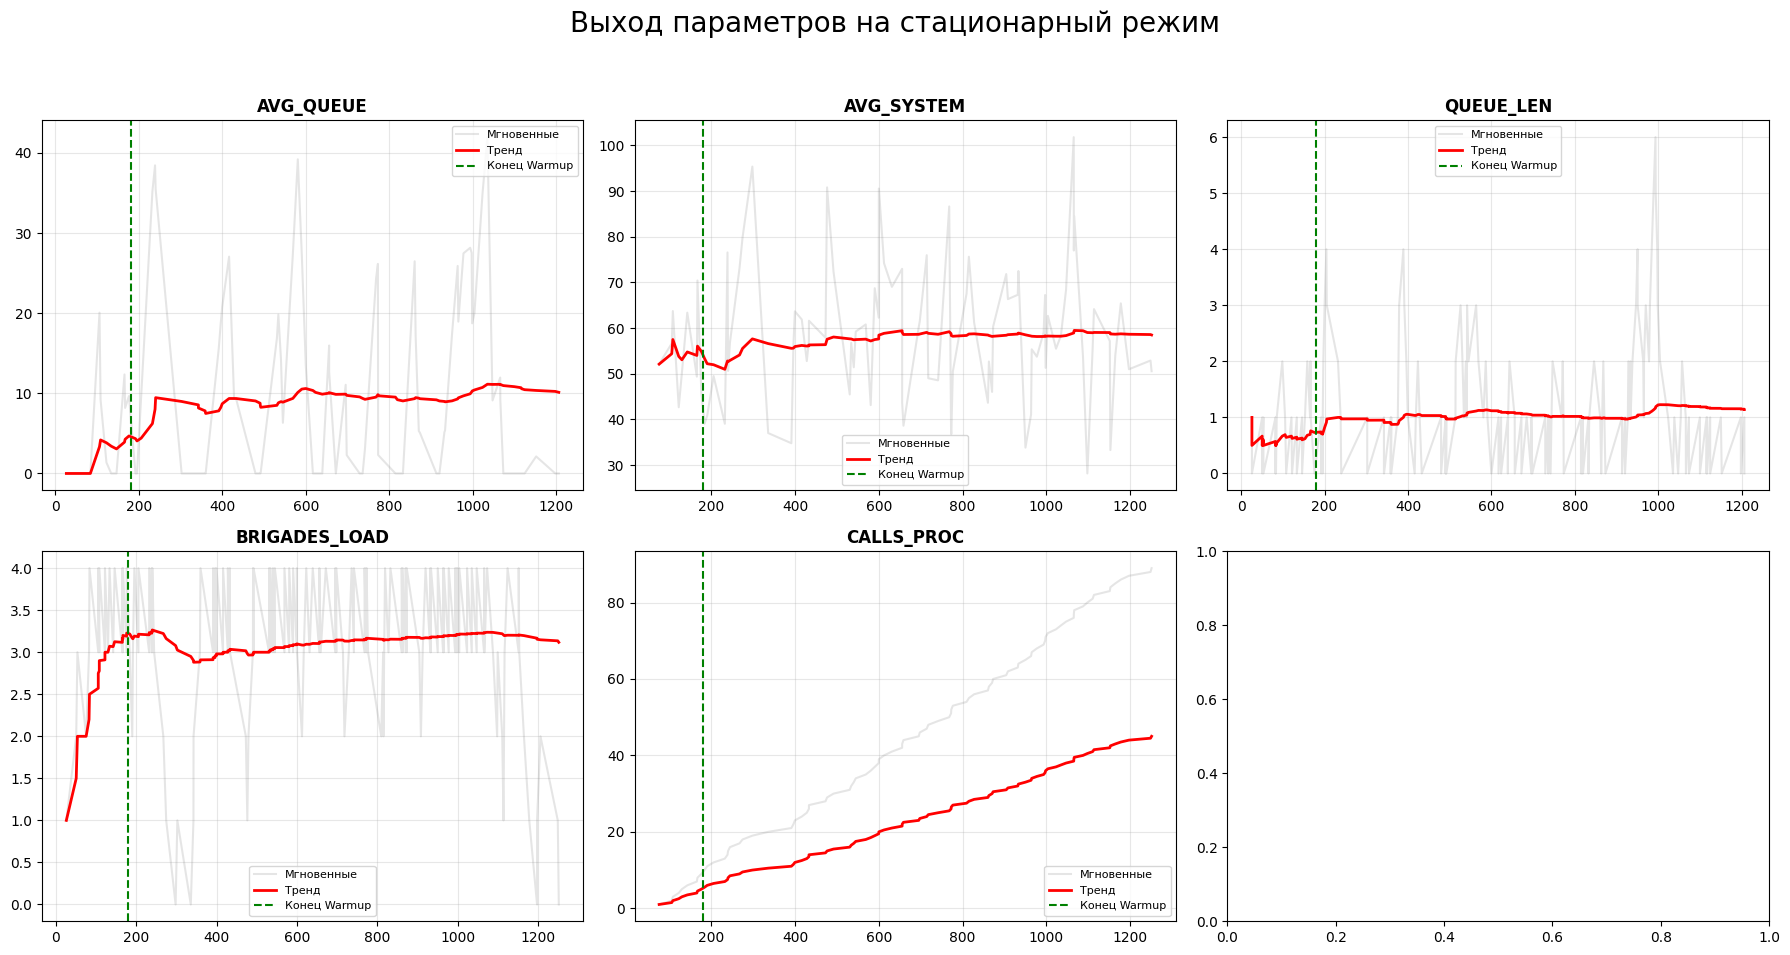


                        Проверка гипотезы о влиянии переходного периода                        
| Параметр        | Среднее (Warm)  | Среднее (No)    | p-value      | Результат       |
|-----------------|-----------------|-----------------|--------------|-----------------|
| AVG_QUEUE       | 11.1707         | 10.1836         | 3.5429e-01   | Незначимо       |
| AVG_SYSTEM      | 60.1154         | 59.0010         | 3.1353e-01   | Незначимо       |
| QUEUE_LEN       | 0.7460          | 0.6769          | 3.5949e-01   | Незначимо       |
| BRIGADES_LOAD   | 2.9617          | 2.8329          | 2.7262e-03   | Значимо         |
| CALLS_PROC      | 85.1417         | 80.5667         | 1.3405e-04   | Значимо         |
Вывод: Если результат значим, переходный период искажает оценку


In [22]:
analyze_warmup_full_study(num_reps=120)

#### Непрерывный прогон

In [23]:
def check_all_continuous_run_hypotheses(num_segments=50):
    global WARMUP_MODE
    n_params = len(ALL_PARAMS)
    cols = 3
    rows = (n_params + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(18, 5 * rows))
    fig.suptitle('Сравнение методов: Репликации vs Непрерывный прогон', fontsize=20)
    axes = axes.flatten()

    print(f"{'Параметр':<15} | {'Среднее (Реп)':<12} | {'Среднее (Непр)':<14} | {'Результат'}")
    print("-" * 75)

    WARMUP_MODE = True
    all_reps_data = {p: [] for p in ALL_PARAMS}
    for _ in range(num_segments):
        run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
        RESULTS_COLLECTOR.finalize_replication()
        for p in ALL_PARAMS:
            val = RESULTS_COLLECTOR.replication_values[p][-1]
            all_reps_data[p].append(val)

    total_long_time = RUN_TIME * num_segments
    full_end_time = WARMUP_TIME + total_long_time
    env = simpy.Environment()
    hospital = Emergency_Hospital(env, NUM_BRIGADES, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
    RESULTS_COLLECTOR.clear_values()
    env.process(call_generator(env, hospital, FREQUENCY, full_end_time))

    env.run(until=WARMUP_TIME)
    hospital.processed_calls = 0
    RESULTS_COLLECTOR.clear_values()

    env.run(until=full_end_time)

    for idx, param in enumerate(ALL_PARAMS):
        if param in CON_PARAMS: raw_data = RESULTS_COLLECTOR.continuous_values[param]
        elif param in CUR_PARAMS: raw_data = RESULTS_COLLECTOR.current_values[param]
        else: raw_data = RESULTS_COLLECTOR.additive_values[param]

        batches = []
        for i in range(num_segments):
            start_t = i * RUN_TIME
            end_t = (i + 1) * RUN_TIME

            segment_points = [p[1] for p in raw_data if start_t <= (p[0] - WARMUP_TIME) < end_t]

            if not segment_points:
                batches.append(0.0)
            else:
                if param in ADD_PARAMS:
                    diff = max(segment_points) - min(segment_points)
                    batches.append(diff)
                else:
                    batches.append(np.mean(segment_points))

        # Статистика
        data_rep = np.array(all_reps_data[param])
        data_cont = np.array(batches)

        # t-тест
        if np.std(data_rep) < 1e-7 and np.std(data_cont) < 1e-7:
            p_val = 1.0
        else:
            _, p_val = stats.ttest_ind(data_rep, data_cont, equal_var=False)

        status = "Принята" if p_val > 0.05 else "Отвергнута"
        print(f"{param:<15} | {np.mean(data_rep):<12.4f} | {np.mean(data_cont):<14.4f} | {status}")

        ax = axes[idx]
        ax.boxplot([data_rep, data_cont], tick_labels=['Репликации', 'Батчи'])
        ax.set_title(f"{param} (p={p_val:.3f})")
        ax.grid(True, alpha=0.2)

    for i in range(idx + 1, len(axes)): fig.delaxes(axes[i])
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


Параметр        | Среднее (Реп) | Среднее (Непр) | Результат
---------------------------------------------------------------------------
AVG_QUEUE       | 12.7080      | 12.3121        | Принята
AVG_SYSTEM      | 61.7088      | 61.3495        | Принята
QUEUE_LEN       | 0.8056       | 1.3207         | Отвергнута
BRIGADES_LOAD   | 2.9364       | 2.9466         | Принята
CALLS_PROC      | 85.7200      | 77.2400        | Отвергнута


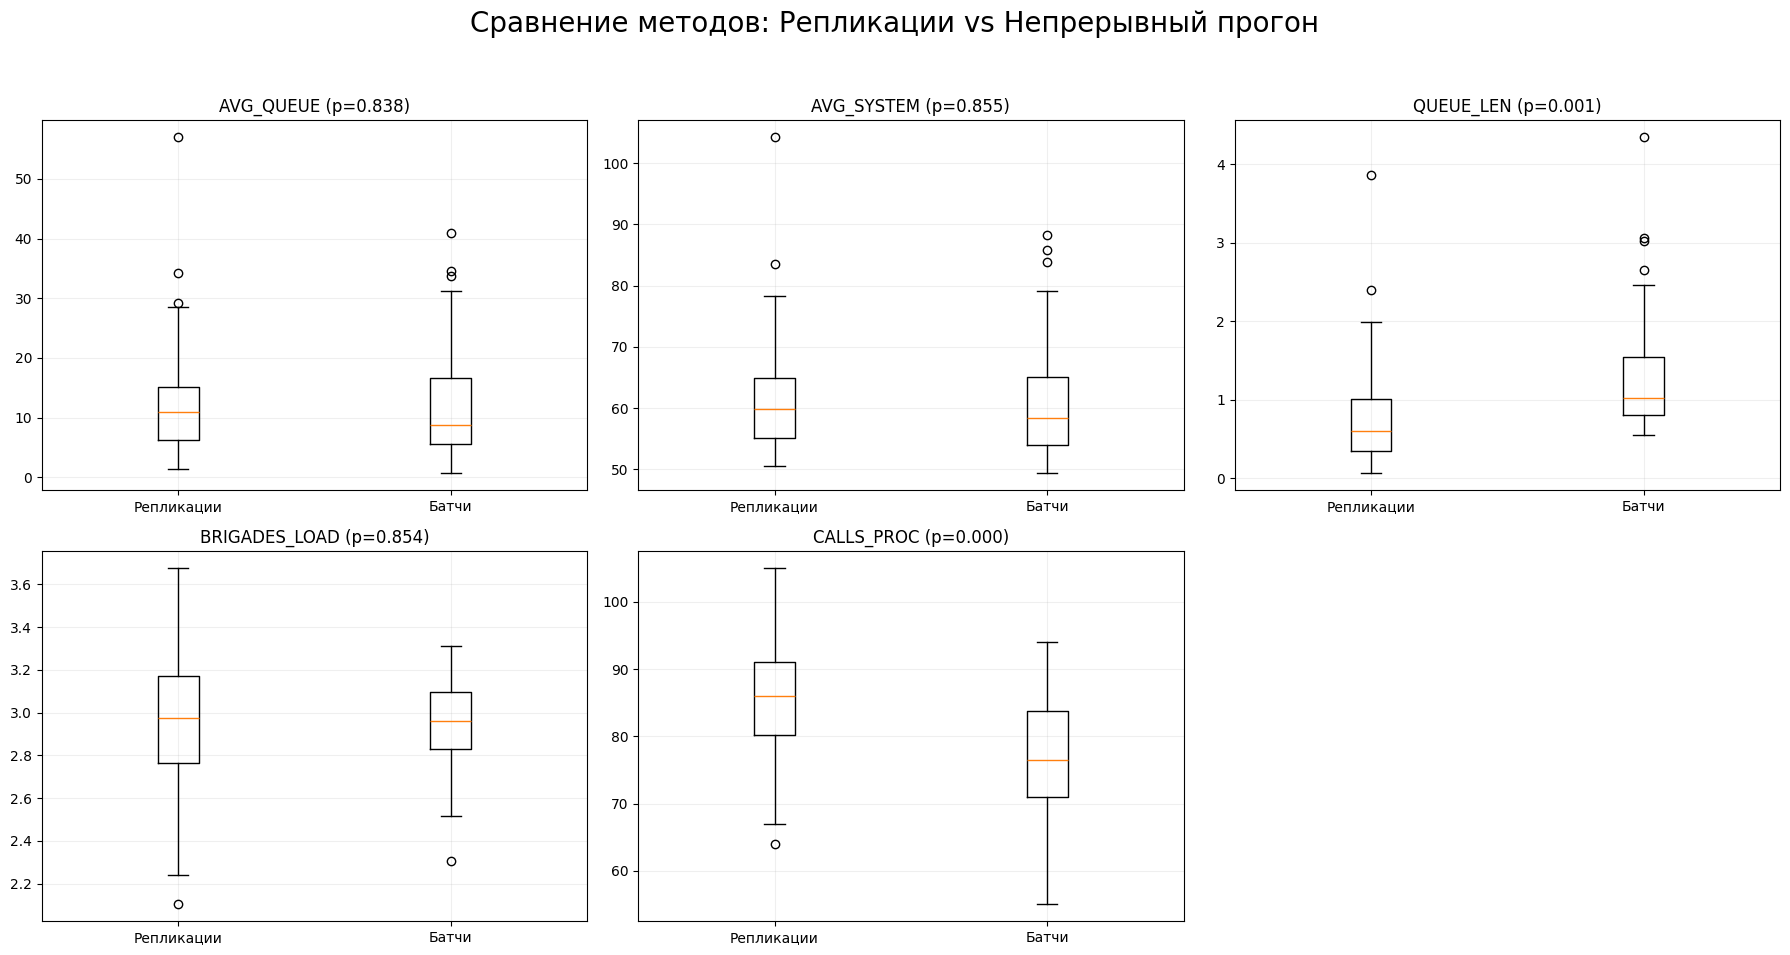

In [24]:
WARMUP_MODE = False
check_all_continuous_run_hypotheses()

#### Чувствительность откликов

In [26]:
def sensitivity_analysis_continuous(param_to_vary='FREQUENCY', variations=[0.9, 1.0, 1.1], num_segments=50):
    global WARMUP_MODE, FREQUENCY
    original_val = 3

    results_queue = {}
    results_calls = {}

    print(f"=== АНАЛИЗ ЧУВСТВИТЕЛЬНОСТИ (Параметр: {param_to_vary}) ===")
    print(f"Метод: Непрерывный прогон ({num_segments} батчей по {RUN_TIME} мин)")
    print("-" * 60)

    total_long_time = RUN_TIME * num_segments
    full_end_time = WARMUP_TIME + total_long_time

    for factor in variations:
        current_val = original_val * factor
        if param_to_vary == 'FREQUENCY':
            FREQUENCY = current_val

        print(f"Тестирование фактора {factor:.1f} ({param_to_vary} = {current_val:.2f})...")

        env = simpy.Environment()
        hospital = Emergency_Hospital(env, NUM_BRIGADES, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
        RESULTS_COLLECTOR.clear_values()

        env.process(call_generator(env, hospital, FREQUENCY, full_end_time))

        env.run(until=WARMUP_TIME)

        hospital.processed_calls = 0
        RESULTS_COLLECTOR.clear_values()

        env.run(until=full_end_time)

        queue_batches = []
        calls_batches = []

        raw_queue = RESULTS_COLLECTOR.current_values['AVG_QUEUE']
        raw_calls = RESULTS_COLLECTOR.additive_values['CALLS_PROC']

        for i in range(num_segments):
            start_t = i * RUN_TIME
            end_t = (i + 1) * RUN_TIME

            q_seg = [p[1] for p in raw_queue if start_t <= (p[0] - WARMUP_TIME) < end_t]
            c_seg = [p[1] for p in raw_calls if start_t <= (p[0] - WARMUP_TIME) < end_t]

            queue_batches.append(np.mean(q_seg) if q_seg else 0.0)
            calls_batches.append(max(c_seg) - min(c_seg) if c_seg else 0.0)

        results_queue[factor] = queue_batches
        results_calls[factor] = calls_batches

    FREQUENCY = original_val

    def get_stats(res_dict):
        base_mean = np.mean(res_dict[1.0])
        S_values = []
        for f in variations:
            if f == 1.0: continue
            cur_mean = np.mean(res_dict[f])
            delta_X = f - 1.0
            delta_Y = (cur_mean - base_mean) / base_mean if base_mean != 0 else 0
            S_values.append(abs(delta_Y / delta_X))
        return np.mean(S_values)

    s_q = get_stats(results_queue)
    s_c = get_stats(results_calls)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    x_numeric = [(f-1)*100 for f in variations]
    x_labels = [f"{int(x)}%" for x in x_numeric]

    def plot_trend(ax, res_dict, s_val, title, color, ylabel):
        means = [np.mean(res_dict[f]) for f in variations]
        stds = [np.std(res_dict[f]) for f in variations]

        ax.fill_between(x_numeric, np.array(means)-np.array(stds), np.array(means)+np.array(stds),
                        color=color, alpha=0.15, label='Разброс батчей (±std)')
        ax.plot(x_numeric, means, 'o-', color=color, linewidth=3, markersize=8, label='Среднее значение')

        for x, y in zip(x_numeric, means):
            ax.annotate(f'{y:.2f}', (x, y), textcoords="offset points", xytext=(0,10), ha='center')

        ax.set_title(f"{title}\nКоэф. чувствительности S = {s_val:.2f}", fontsize=13, fontweight='bold')
        ax.set_xlabel("Изменение входного параметра ΔX (%)")
        ax.set_ylabel(ylabel)
        ax.set_xticks(x_numeric)
        ax.set_xticklabels(x_labels)
        ax.grid(True, linestyle=':', alpha=0.6)
        ax.legend()

    plot_trend(ax1, results_queue, s_q, "Чувствительность AVG_QUEUE", "firebrick", "Время ожидания (мин)")
    plot_trend(ax2, results_calls, s_c, "Чувствительность CALLS_PROC", "royalblue", "Кол-во обработанных звонков")

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(9, 5))

    def rel_change(res_dict):
        base = np.mean(res_dict[1.0])
        return [(np.mean(res_dict[f]) - base) / base * 100 for f in variations]

    plt.plot(x_numeric, rel_change(results_queue), 's-', color='firebrick', linewidth=2.5, label=f'AVG_QUEUE (S={s_q:.2f})')
    plt.plot(x_numeric, rel_change(results_calls), 's-', color='royalblue', linewidth=2.5, label=f'CALLS_PROC (S={s_c:.2f})')

    plt.plot(x_numeric, x_numeric, '--', color='gray', alpha=0.5, label='Линейный отклик (S=1)')

    plt.title("Диаграмма относительной чувствительности откликов", fontsize=14)
    plt.xlabel("Изменение входа (ΔX, %)")
    plt.ylabel("Изменение отклика (ΔY, %)")
    plt.axhline(0, color='black', linewidth=0.8, alpha=0.3)
    plt.axvline(0, color='black', linewidth=0.8, alpha=0.3)
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.show()

    print(f"1. AVG_QUEUE: S = {s_q:.4f} -> Достаточная точность входа: {5/s_q:.2f}%")
    print(f"2. CALLS_PROC: S = {s_c:.4f} -> Достаточная точность входа: {5/s_c:.2f}%")


=== АНАЛИЗ ЧУВСТВИТЕЛЬНОСТИ (Параметр: FREQUENCY) ===
Метод: Непрерывный прогон (50 батчей по 1200 мин)
------------------------------------------------------------
Тестирование фактора 0.9 (FREQUENCY = 2.70)...
Тестирование фактора 1.0 (FREQUENCY = 3.00)...
Тестирование фактора 1.1 (FREQUENCY = 3.30)...


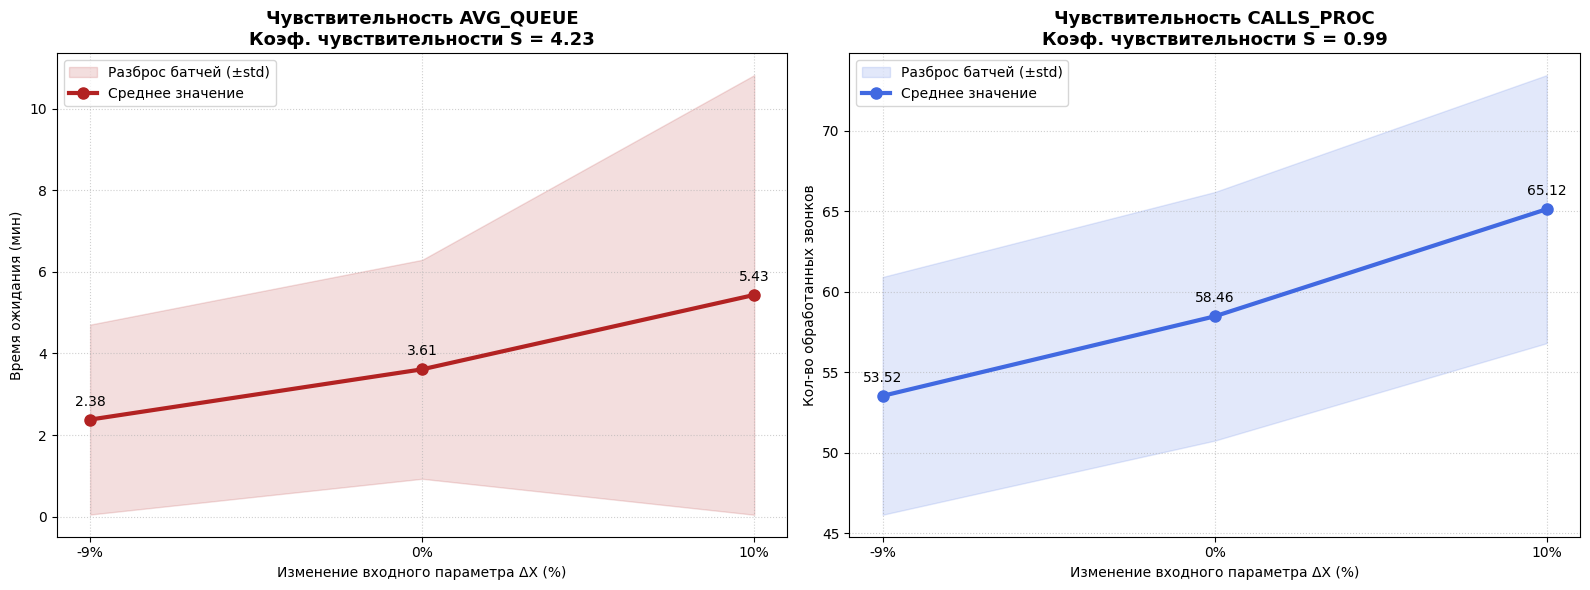

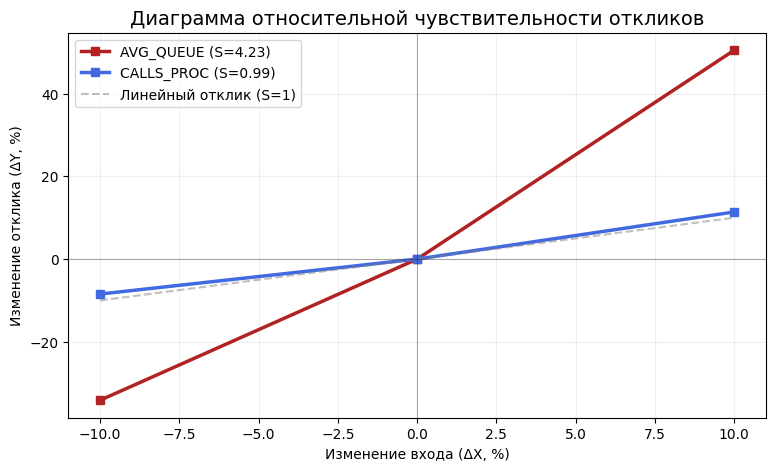

1. AVG_QUEUE: S = 4.2308 -> Достаточная точность входа: 1.18%
2. CALLS_PROC: S = 0.9921 -> Достаточная точность входа: 5.04%


In [27]:
sensitivity_analysis_continuous()

### Постановка экспериментов с имитационной моделью

Линейная аппроксимация

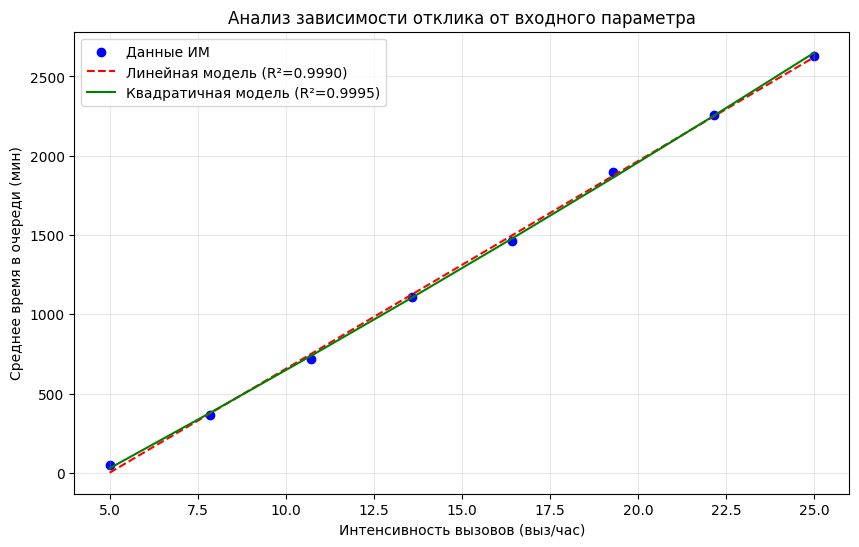

Коэффициент детерминации (Линейная): 0.9990
Коэффициент детерминации (Квадратичная): 0.9995


In [28]:
def task_1_approximation():
    global FREQUENCY
    freq_levels = np.linspace(5, 25, 8)
    avg_queues = []

    for f in freq_levels:
        FREQUENCY = f
        RESULTS_COLLECTOR.replication_values = {param: [] for param in ALL_PARAMS}
        for _ in range(25):
            run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
            RESULTS_COLLECTOR.finalize_replication()
        avg_queues.append(np.mean(RESULTS_COLLECTOR.replication_values['AVG_QUEUE']))

    x = freq_levels
    y = np.array(avg_queues)

    p1 = np.polyfit(x, y, 1)
    y_pred_lin = np.polyval(p1, x)
    r2_lin = 1 - (np.sum((y - y_pred_lin)**2) / np.sum((y - np.mean(y))**2))

    p2 = np.polyfit(x, y, 2)
    y_pred_poly = np.polyval(p2, x)
    r2_poly = 1 - (np.sum((y - y_pred_poly)**2) / np.sum((y - np.mean(y))**2))

    plt.figure(figsize=(10, 6))
    plt.scatter(x, y, color='blue', label='Данные ИМ')
    plt.plot(x, y_pred_lin, 'r--', label=f'Линейная модель (R²={r2_lin:.4f})')
    plt.plot(x, y_pred_poly, 'g-', label=f'Квадратичная модель (R²={r2_poly:.4f})')
    plt.xlabel('Интенсивность вызовов (выз/час)')
    plt.ylabel('Среднее время в очереди (мин)')
    plt.title('Анализ зависимости отклика от входного параметра')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    print(f"Коэффициент детерминации (Линейная): {r2_lin:.4f}")
    print(f"Коэффициент детерминации (Квадратичная): {r2_poly:.4f}")

task_1_approximation()

#### Отказ ресурсов

In [29]:
def task_2_stability_test():
    global NUM_BRIGADES
    base_brigades = NUM_BRIGADES
    stability_data = []

    for current_num in range(base_brigades, 0, -1):
        NUM_BRIGADES = current_num
        RESULTS_COLLECTOR.clear_values()

        test_run_time = 3000
        env = simpy.Environment()
        hospital = Emergency_Hospital(env, NUM_BRIGADES, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
        env.process(call_generator(env, hospital, 3, test_run_time))
        env.run(until=test_run_time)

        q_values = [p[1] for p in RESULTS_COLLECTOR.continuous_values['QUEUE_LEN']]
        mid = len(q_values) // 2
        trend_ratio = np.mean(q_values[mid:]) / np.mean(q_values[:mid]) if np.mean(q_values[:mid]) > 0 else 1.0

        stability_data.append((current_num, np.mean(q_values), trend_ratio))
        print(f"Бригад: {current_num} | Ср. очередь: {np.mean(q_values):.2f} | Коэф. тренда: {trend_ratio:.2f}")

    NUM_BRIGADES = base_brigades

task_2_stability_test()

Бригад: 4 | Ср. очередь: 0.72 | Коэф. тренда: 0.99
Бригад: 3 | Ср. очередь: 0.91 | Коэф. тренда: 0.76
Бригад: 2 | Ср. очередь: 7.44 | Коэф. тренда: 2.02
Бригад: 1 | Ср. очередь: 47.00 | Коэф. тренда: 2.79


#### Варианты улучшения

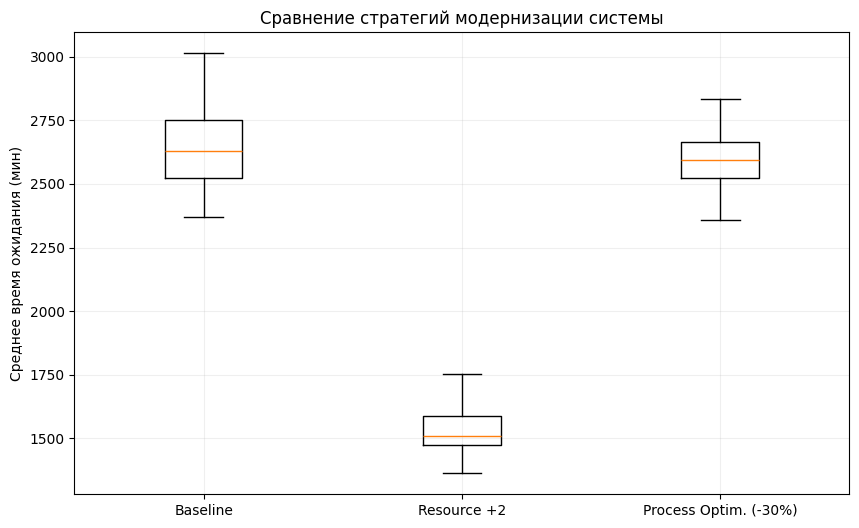

Сценарий 'Baseline': среднее = 2641.8275, ст. откл = 146.6061
Сценарий 'Resource +2': среднее = 1526.4216, ст. откл = 87.6050
Сценарий 'Process Optim. (-30%)': среднее = 2597.5182, ст. откл = 115.6178


In [34]:
def task_3_alternatives():
    global NUM_BRIGADES, AVG_RECEPTION_TIME
    original_params = (NUM_BRIGADES, AVG_RECEPTION_TIME)

    alternatives = {
        "Baseline": (original_params[0], original_params[1]),
        "Resource +2": (original_params[0] + 2, original_params[1]),
        "Process Optim. (-30%)": (original_params[0], original_params[1] * 0.7)
    }

    all_results = {}
    for name, config in alternatives.items():
        NUM_BRIGADES, AVG_RECEPTION_TIME = config
        reps = []
        for _ in range(40):
            run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
            RESULTS_COLLECTOR.finalize_replication()
            reps.append(RESULTS_COLLECTOR.replication_values['AVG_QUEUE'][-1])
        all_results[name] = reps

    plt.figure(figsize=(10, 6))
    plt.boxplot(all_results.values(), tick_labels=all_results.keys())
    plt.title('Сравнение стратегий модернизации системы')
    plt.ylabel('Среднее время ожидания (мин)')
    plt.grid(True, alpha=0.2)
    plt.show()

    for name, data in all_results.items():
        print(f"Сценарий '{name}': среднее = {np.mean(data):.4f}, ст. откл = {np.std(data):.4f}")

    NUM_BRIGADES, AVG_RECEPTION_TIME = original_params # Сброс

task_3_alternatives()

#### Двухфакторный эксперимент

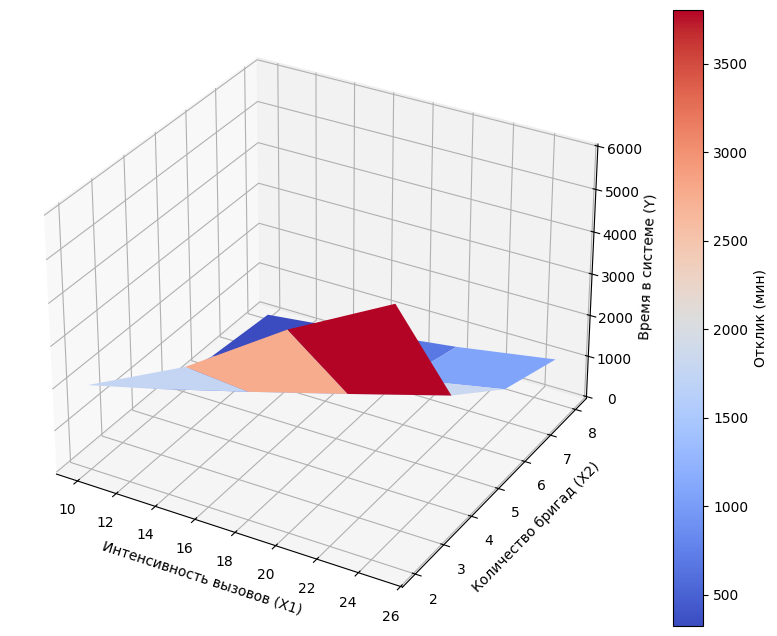

In [35]:
from matplotlib import cm

def task_4_two_factor_experiment():
    global FREQUENCY, NUM_BRIGADES

    freq_axis = np.linspace(10, 25, 4)
    brig_axis = np.array([2, 4, 6, 8])

    X, Y = np.meshgrid(freq_axis, brig_axis)
    Z = np.zeros(X.shape)

    for i in range(len(brig_axis)):
        for j in range(len(freq_axis)):
            NUM_BRIGADES = int(Y[i, j])
            FREQUENCY = X[i, j]

            temp_results = []
            for _ in range(10):
                run_simulation(FREQUENCY, AVG_RECEPTION_TIME, AVG_PROCESSING_TIME)
                RESULTS_COLLECTOR.finalize_replication()
                temp_results.append(RESULTS_COLLECTOR.replication_values['AVG_SYSTEM'][-1])
            Z[i, j] = np.mean(temp_results)

    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, cmap=cm.coolwarm, antialiased=True)

    ax.set_xlabel('Интенсивность вызовов (X1)')
    ax.set_ylabel('Количество бригад (X2)')
    ax.set_zlabel('Время в системе (Y)')
    fig.colorbar(surf, label='Отклик (мин)')
    plt.show()

task_4_two_factor_experiment()